In [1]:
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser
import cv2
from tqdm import tqdm
from arguments import ModelParams, PipelineParams, ModelHiddenParams
from scene import Scene, GaussianModel
from gaussian_renderer import render, render_contrastive_feature, render_segmentation, render_mask
from segment_anything import (SamAutomaticMaskGenerator, SamPredictor, sam_model_registry)
import imageio
from utils.segment_utils import *
from kmeans_pytorch import kmeans

%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Hyper-parameters

In [2]:
FEATURE_DIM = 32

DATA_ROOT = './data/hypernerf/chickchicken'
MODEL_PATH = './output/hypernerf/chickchicken'
GAUSSIAN_ITERATION = 14000

SAM_PROJ_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(GAUSSIAN_ITERATION)}/sam_proj.pt')
FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(GAUSSIAN_ITERATION)}/feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

SAM_ARCH = 'vit_h'
SAM_CKPT_PATH = '/data/sxj/dependencies/sam_ckpt/sam_vit_h_4b8939.pth'

## Data and Model Preparation

In [3]:
parser = ArgumentParser(description="Render script parameters")
model = ModelParams(parser, sentinel=True)
# op = OptimizationParams(parser)
pipeline = PipelineParams(parser)
hp = ModelHiddenParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument('--mode', default='feature', choices=['scene', 'feature'])
parser.add_argument("--configs", type=str, default = "./arguments/hypernerf/chicken.py")
# parser.add_argument('--precomputed_mask', default=None, type=str)
args = get_combined_args(parser, MODEL_PATH, 'feature')
if args.configs:
    import mmcv
    from utils.params_utils import merge_hparams
    config = mmcv.Config.fromfile(args.configs)
    args = merge_hparams(args, config)

dataset = model.extract(args)
hyperparam = hp.extract(args)
dataset.need_features = True
dataset.need_masks = True

gaussians = GaussianModel(dataset.sh_degree, args.mode, hyperparam, dataset.feature_dim)
scene = Scene(dataset, gaussians, load_iteration=args.iteration, mode=args.mode)

xyz = gaussians.get_xyz
point_features = gaussians.get_sam_features
# print(xyz.device)
# print(point_features.device)

Looking for config file in ./output/hypernerf/chickchicken/feature_cfg_args
Config file found at: ./output/hypernerf/chickchicken/feature_cfg_args
Feature Dimension:  32
mode:  feature
Loading trained model at iteration 14000
load finished


114it [00:00, 57065.36it/s]

format finished
Loading Training Cameras
Loading Test Cameras
Loading Video Cameras
Deformation Net Set aabb [ 81.62185669  25.49359322 291.8190918 ] [ -34.72369003 -174.75157166   12.67879772]
Voxel Plane: set aabb= Parameter containing:
tensor([[  81.6219,   25.4936,  291.8191],
        [ -34.7237, -174.7516,   12.6788]])


loading model from exists./output/hypernerf/chickchicken/point_cloud/iteration_14000


## Load SAM

In [4]:
model_type = SAM_ARCH
sam = sam_model_registry[model_type](checkpoint=SAM_CKPT_PATH).to('cuda')
predictor = SamPredictor(sam)

## Begin Segmentation

In [5]:
bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
bg_color = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
bg_feature = [0 for i in range(FEATURE_DIM)]
bg_feature = torch.tensor(bg_feature, dtype=torch.float32, device="cuda")

cameras = [i for i in scene.getVideoCameras()]
test_views = [i for i in scene.getTestCameras()]
cam_type = scene.dataset_type
print("There are",len(cameras),"views in the dataset.")

There are 456 views in the dataset.


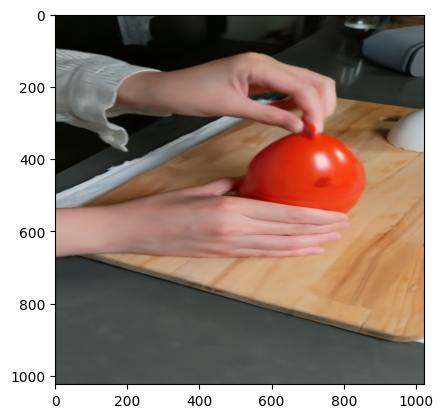

In [6]:
ref_img_camera_id = 0
view = cameras[ref_img_camera_id]

with torch.no_grad():
    rendering = render(view, gaussians, pipeline, bg_color, cam_type=cam_type)["render"]
    img = to8b(rendering).transpose(1,2,0)
    img = cv2.resize(img, dsize=(1024,1024), fx=1, fy=1, interpolation=cv2.INTER_LINEAR)
    plt.imshow(img)
    # plt.axis('off')
    plt.show()

In [7]:
with torch.no_grad():
    predictor.set_image(img)
    sam_feature = predictor.features
    # sam_feature = view.original_features

    rendered_feature = render_contrastive_feature(view, gaussians, pipeline.extract(args), bg_feature)['render']

H, W = sam_feature.shape[-2:]
print("sam_features shape: ", sam_feature.shape)
print("rendered_feature shape: ", rendered_feature.shape)

sam_features shape:  torch.Size([1, 256, 64, 64])
rendered_feature shape:  torch.Size([32, 960, 536])


Visualize the SAM feature map and rendered feature map.

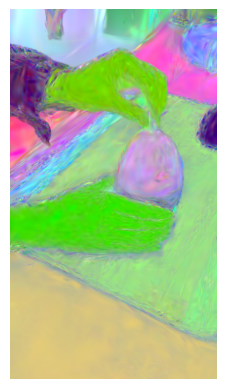

In [8]:
import numpy as np
from sklearn.decomposition import PCA

feature  = rendered_feature.squeeze().detach().cpu().numpy()
# Feature dimension can be 512 for LSeg or 256 for SAM
feature_dimension, h, w = feature.shape

# Flatten the data for PCA while sampling every third element
feature_flattened = feature.reshape(-1, feature_dimension)#[:, ::3]

# Initialize PCA with 3 components for RGB visualization
pca = PCA(n_components=3)
pca.fit(feature_flattened)

# Transform the feature map using the PCA components and mean
# Centering the features with PCA mean
# Projecting them onto PCA components
# Assuming 'feature_map' is the input data to be transformed
# feature_map = np.random.rand(h, w, feature_dimension)  # Replace with your actual feature map
feature_map = feature.transpose((1, 2, 0))
feature_map_flattened = feature_map.reshape(-1, feature_dimension)
feature_map_centered = feature_map_flattened - pca.mean_
feature_map_transformed = pca.transform(feature_map_centered)

# Reshape to original width and height with 3 channels for the RGB components
feature_map_transformed = feature_map_transformed.reshape(h, w, 3)

# Normalize the transformed feature map for visualization
# Remove outliers if necessary and standardize to the [0, 1] range
feature_min, feature_max = np.percentile(feature_map_transformed, [2, 98])
feature_map_normalized = (feature_map_transformed - feature_min) / (feature_max - feature_min)
feature_map_normalized = np.clip(feature_map_normalized, 0, 1)  # Ensuring the values are within [0, 1]

# Now, 'feature_map_normalized' can be used for visualization as an RGB image.
plt.imshow(feature_map_normalized)
plt.axis('off')
plt.show()

## Input Prompts

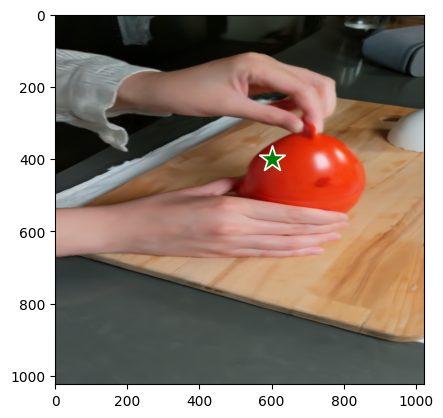

In [9]:
input_point = np.array([[600, 400]])
input_label = np.ones(len(input_point))

# plt.figure(figsize=(10,10))
plt.imshow(img)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

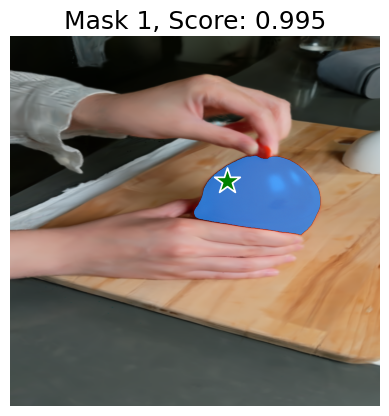

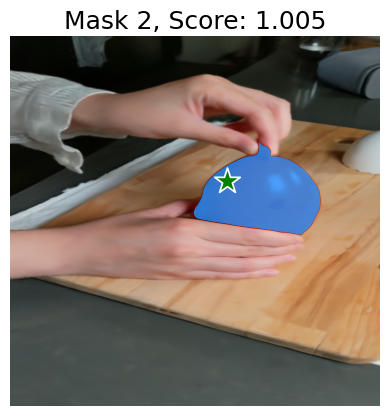

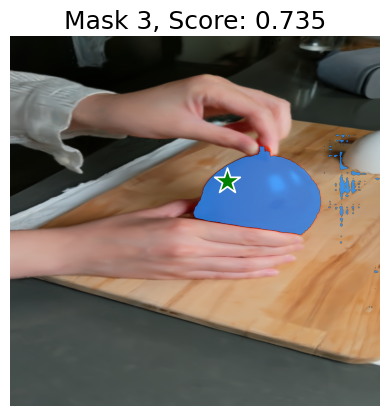

In [10]:
with torch.no_grad():
    vanilla_masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    
l = len(vanilla_masks)

for i, (mask, score) in enumerate(zip(vanilla_masks, scores)):
    plt.figure()
    # plt.subplot(1, l, i+1)
    plt.imshow(img)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [11]:
print("vanilla_masks: ", vanilla_masks.shape)
masks = torch.nn.functional.interpolate(torch.from_numpy(vanilla_masks).float().unsqueeze(0), (64,64), mode='bilinear').squeeze(0).cuda()
masks[masks > 0.5] = 1
masks[masks != 1] = 0
print("masks resized: ", masks.shape)

vanilla_masks:  (3, 1024, 1024)
masks resized:  torch.Size([3, 64, 64])


## Generate Average Pooled SAM Feature Query

In [12]:
# mask_id = 0
mask_id = np.argmax(scores)
origin_ref_mask = torch.tensor(vanilla_masks[mask_id]).float().cuda()

if origin_ref_mask.shape != (64,64):
    ref_mask = torch.nn.functional.interpolate(origin_ref_mask[None, None, :, :], (64,64), mode='bilinear').squeeze().cuda()
    ref_mask[ref_mask > 0.5] = 1
    ref_mask[ref_mask != 1] = 0
else:
    ref_mask = origin_ref_mask
    
# sam features
low_dim_features = gaussians._sam_proj(
    sam_feature.view(-1, H*W).permute([1,0])
).squeeze().permute([1,0]).reshape([-1, H, W])

# Feature Field query
mask_low_dim_features = ref_mask.unsqueeze(0) * low_dim_features
mask_pooling_prototype = mask_low_dim_features.sum(dim = (1,2)) / torch.count_nonzero(ref_mask)
# ref_mask = torch.nn.functional.interpolate(origin_ref_mask[None, None, :, :], rendered_feature.shape[-2:], mode='bilinear').squeeze().cuda()
# ref_mask[ref_mask > 0.5] = 1
# ref_mask[ref_mask != 1] = 0
# mask_low_dim_features = ref_mask.unsqueeze(0) * rendered_feature
# mask_pooling_prototype = mask_low_dim_features.sum(dim = (1,2)) / torch.count_nonzero(ref_mask)

In [13]:
import kmeans_pytorch
import importlib
importlib.reload(kmeans_pytorch)
from kmeans_pytorch import kmeans

# K-means or not
rendered_feature = render_contrastive_feature(view, gaussians, pipeline.extract(args), bg_feature)['render']

# similarity = torch.cosine_similarity(mask_pooling_prototype.cuda(), rendered_feature.permute([1, 2, 0]), dim=-1)

similarity_mask = torch.einsum('C,CHW->HW', mask_pooling_prototype.cuda(), rendered_feature)
similarity_mask = torch.nn.functional.interpolate(similarity_mask.float().unsqueeze(0).unsqueeze(0), (64,64), mode='bilinear').squeeze().cuda()
similarity_mask[similarity_mask > 0] = 1
similarity_mask[similarity_mask != 1] = 0

# ref_mask = torch.nn.functional.interpolate(origin_ref_mask[None, None, :, :], (64, 64), mode='bilinear').squeeze().cuda()
# ref_mask[ref_mask > 0.5] = 1
# ref_mask[ref_mask != 1] = 0

iob = (similarity_mask * ref_mask).sum(dim = (-1, -2)) / ref_mask.sum()
print(iob.item())

if iob > 0.9:
    fmask_prototype = mask_pooling_prototype.unsqueeze(0)
else:
    # fmask_prototype = mask_pooling_prototype.unsqueeze(0)
    downsampled_masks = torch.nn.functional.adaptive_avg_pool2d(ref_mask.unsqueeze(0).unsqueeze(0), (8,8)).squeeze()
    downsampled_features = torch.nn.functional.adaptive_avg_pool2d(mask_low_dim_features.unsqueeze(0), (8,8)).squeeze(0)
    downsampled_features /= downsampled_masks.unsqueeze(0)

    downsampled_masks[downsampled_masks != 0]= 1
    init_prototypes = downsampled_features[:, downsampled_masks.bool()].permute([1,0])

    masked_sam_features = low_dim_features[:, ref_mask.bool()]
    masked_sam_features = masked_sam_features.permute([1,0])
    
    num_clusters = init_prototypes.shape[0]
    print(num_clusters)
    
    if num_clusters <= 1:
        num_clusters = min(int(masked_sam_features.shape[0] ** 0.5), 32)
        init_prototypes = []

    cluster_ids_x, cluster_centers = kmeans(
        X=masked_sam_features, num_clusters=num_clusters, distance='cosine', device=torch.device('cuda')
    )

    similarity_mask = torch.sigmoid(torch.einsum('NC,CHW->NHW', cluster_centers.cuda(), rendered_feature))
    similarity_mask = torch.nn.functional.interpolate(similarity_mask.float().unsqueeze(1), (64,64), mode='bilinear').squeeze().cuda()
    similarity_mask[similarity_mask >= 0.5] = 1
    similarity_mask[similarity_mask != 1] = 0
    similarity_mask = similarity_mask.squeeze()

    ioa = (similarity_mask * ref_mask[None,:,:]).sum(dim = (-1, -2)) / (similarity_mask.sum(dim = (-1, -2)) + 1e-5)
    iob = (similarity_mask * ref_mask[None,:,:]).sum(dim = (-1, -2)) / ref_mask.sum()
    ioa = ioa.squeeze()
    iob = iob.squeeze()
    cluster_mask = ioa > 0.75

    # NMS
    for i in range(len(cluster_mask)):
        if not cluster_mask[i]:
            continue

        for j in range(i+1, len(cluster_mask)):
            if not cluster_mask[j]:
                continue

            if (similarity_mask[j] * similarity_mask[i]).sum() / ((similarity_mask[j] + similarity_mask[i]).sum() - (similarity_mask[j] * similarity_mask[i]).sum()) > 0.75:
                if ioa[i] > ioa[j]:
                    cluster_mask[j] = False
                else:
                    cluster_mask[i] = False
                    break
    
    cluster_centers = cluster_centers.cuda()
    cluster_centers = cluster_centers[cluster_mask, :]
    fmask_prototype = torch.cat([mask_pooling_prototype.unsqueeze(0), cluster_centers.cuda()], dim = 0)

0.9910314083099365


## Get the initial segmentation through feature match.

In [14]:
mask_prototype = fmask_prototype
if mask_prototype.shape[0] == 1 or len(mask_prototype.shape) == 1:
    print("Using masked average pooling feature as the query")
    point_logits = torch.einsum('NC,C->N', point_features, mask_prototype.squeeze())
    point_scores = torch.sigmoid(point_logits)
else:
    print("Using K-Means features as queries")
    point_logits = torch.einsum('NC,LC->NL', point_features, mask_prototype)
    point_logits = point_logits.max(-1)[0]
    point_scores = torch.sigmoid(point_logits)
    
two_d_point_logits = torch.einsum('NC,CHW->NHW', mask_prototype.cuda(), rendered_feature).max(dim = 0)[0]
two_d_point_logits = torch.nn.functional.interpolate(two_d_point_logits.float()[None, None, ...], ref_mask.shape[-2:], mode='bilinear').squeeze().cuda()
in_mask_logits = two_d_point_logits[ref_mask.bool()]

# Adjustable Threshold
thresh = max(max(in_mask_logits.mean() + in_mask_logits.std(), torch.topk(point_logits, int(point_logits.shape[0]*0.1))[0][-1]), 0)
# thresh = in_mask_logits.mean() - in_mask_logits.std()

mask = point_logits > thresh
os.makedirs(os.path.join('./segmentation_res/'), exist_ok=True)
# torch.save(mask, './segmentation_res/test_mask.pt')
print("Total Gaussians Number: ", xyz.shape[0])
print("Segmented Gaussians NUmber: ", torch.count_nonzero(mask).item())

Using masked average pooling feature as the query
Total Gaussians Number:  110862
Segmented Gaussians NUmber:  157


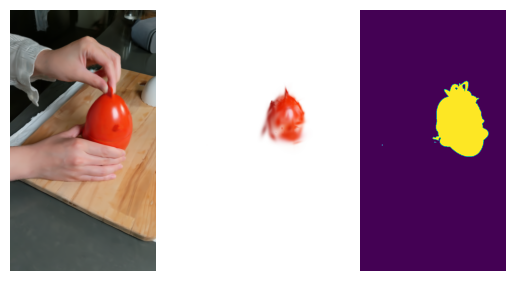

In [15]:
with torch.no_grad():
    rendering = render(view, gaussians, pipeline, bg_color, cam_type=cam_type)["render"]
    target_img = to8b(rendering).transpose(1,2,0)
    target_seg = render_segmentation(view, gaussians, pipeline, bg_color, mask)["render"]
    target_img_seg = to8b(target_seg.detach()).transpose(1,2,0)
    rendered_mask = render_mask(view, gaussians, pipeline, bg_color, precomputed_mask=mask.float())["mask"]
    rendered_mask = rendered_mask.squeeze().detach().cpu() > 0

plt.subplot(1,3,1)
plt.imshow(target_img)
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(target_img_seg)
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(rendered_mask.detach().cpu())
plt.axis("off")
plt.show()

In [22]:
opacity = gaussians._opacity
shs = gaussians.get_features
means3D = gaussians.get_xyz
scales = gaussians._scaling
rotations = gaussians._rotation
ts = torch.tensor(view.time).to(means3D.device).repeat(means3D.shape[0],1)
means3D_final, scales_final, rotations_final, opacity_final, shs_final = gaussians._deformation(means3D, scales, rotations, opacity, shs, ts)

selected_xyz = means3D_final[mask.cpu()].data
selected_score = point_scores[mask.cpu()]
selected_xyz, thresh, mask_ = postprocess_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask = mask.clone(), max_time=1)
filtered_points, filtered_mask, thresh = postprocess_grad_based_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask=mask_.clone(), 
                                                                                    gaussians=gaussians, view=view, sam_mask=ref_mask.clone(), 
                                                                                    pipeline_args=pipeline.extract(args), bg_color=bg_color)
final_xyz, point_mask, final_normals = postprocess_growing(means3D_final, None, torch.from_numpy(filtered_points).cuda(), None, max(thresh, 0.05), grow_iter = 1)

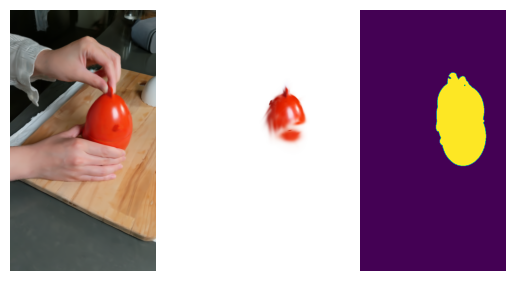

In [24]:
with torch.no_grad():
    rendering = render(view, gaussians, pipeline, bg_color, cam_type=cam_type)["render"]
    target_img = to8b(rendering).transpose(1,2,0)
    target_seg = render_segmentation(view, gaussians, pipeline, bg_color, point_mask)["render"]
    target_img_seg = to8b(target_seg.detach()).transpose(1,2,0)
    rendered_mask = render_mask(view, gaussians, pipeline, bg_color, precomputed_mask=point_mask.float())["mask"]
    rendered_mask = rendered_mask.squeeze().detach().cpu() > 0

plt.subplot(1,3,1)
plt.imshow(target_img)
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(target_img_seg)
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(rendered_mask.detach().cpu())
plt.axis("off")
plt.show()

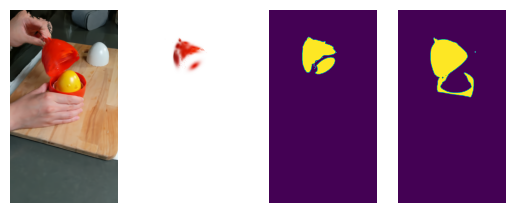

In [21]:
target_view = test_views[90]
with torch.no_grad():
    rendering= render(target_view, gaussians, pipeline, bg_color, cam_type=cam_type)["render"]
    target_img = to8b(rendering).transpose(1,2,0)
    target_seg = render_segmentation(target_view, gaussians, pipeline, bg_color, filtered_mask)["render"]
    target_img_seg = to8b(target_seg.detach()).transpose(1,2,0)
    rendered_mask = render_mask(target_view, gaussians, pipeline, bg_color, precomputed_mask=filtered_mask.float())["mask"]
    rendered_mask = rendered_mask.squeeze().detach().cpu() > 0

plt.subplot(1,4,1)
plt.imshow(target_img)
plt.axis("off")
plt.subplot(1,4,2)
plt.imshow(target_img_seg)
plt.axis("off")
plt.subplot(1,4,3)
plt.imshow(rendered_mask.detach().cpu())
plt.axis("off")
plt.subplot(1,4,4)
plt.imshow(target_view.gt_mask.squeeze())
plt.axis("off")
plt.show()

In [222]:
opacity = gaussians._opacity
shs = gaussians.get_features
means3D = gaussians.get_xyz
scales = gaussians._scaling
rotations = gaussians._rotation
ts = torch.tensor(target_view.time).to(means3D.device).repeat(means3D.shape[0],1)
means3D_final, scales_final, rotations_final, opacity_final, shs_final = gaussians._deformation(means3D, scales, rotations, opacity, shs, ts)

In [189]:
gaussians._xyz = means3D_final
# gaussians._opacity = opacity_final
# gaussians._scaling = scales_final
# gaussians._rotation = rotations_final
gaussians.save_ply("./test.ply")

In [229]:
selected_xyz = means3D_final[filtered_mask.cpu()].data
final_xyz, point_mask, final_normals = postprocess_growing(means3D_final, None, selected_xyz, None, 0.4, grow_iter = 1)
# selected_xyz, thresh, mask_ = postprocess_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask=mask.clone(), max_time=15)
# print(mask_.count_nonzero())

In [83]:
rest = mask ^ mask_
selected_xyz = means3D_final[rest.cpu()].data
# selected_xyz, thresh, mask_ = postprocess_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask=rest.clone(), max_time=15)
final_xyz, point_mask, final_normals = postprocess_growing(means3D_final, None, selected_xyz, None, 0.05, grow_iter = 1)

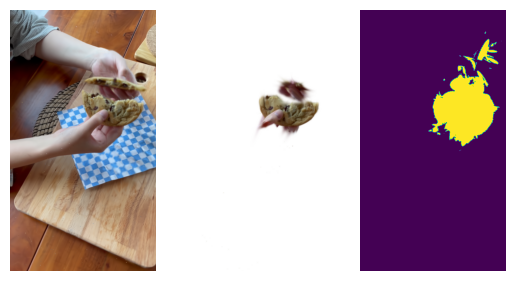

In [230]:
with torch.no_grad():
    rendering = render(target_view, gaussians, pipeline, bg_color, cam_type=cam_type)["render"]
    target_img = to8b(rendering).transpose(1,2,0)
    target_seg = render_segmentation(target_view, gaussians, pipeline, bg_color, point_mask)["render"]
    target_img_seg = to8b(target_seg.detach()).transpose(1,2,0)
    rendered_mask = render_mask(target_view, gaussians, pipeline, bg_color, precomputed_mask=point_mask.float())["mask"]
    rendered_mask = rendered_mask.squeeze().detach().cpu() > 0

plt.subplot(1,3,1)
plt.imshow(target_img)
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(target_img_seg)
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(rendered_mask.detach().cpu())
plt.axis("off")
plt.show()

In [60]:
num_centers = 4
cluster_ids_x, cluster_centers = kmeans(X=means3D_final[mask], num_clusters=num_centers, distance='euclidean', device=torch.device('cuda'))
final_mask = torch.zeros(means3D.shape[0], device = 'cuda').bool()
for c in range(num_centers):
    m = torch.zeros(means3D.shape[0], device = 'cuda').bool()
    m[mask] = (cluster_ids_x == c).cuda()
    print(f"center {c}: before {m.count_nonzero()}")
    
    selected_xyz = means3D_final[m.cpu()].data
    selected_xyz, thresh, mask_ = postprocess_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask=m.clone(), max_time=10)
    final_xyz, point_mask, final_normals = postprocess_growing(means3D_final, None, selected_xyz, None, max(thresh, 0.05), grow_iter = 1)
    print(f"center {c}: after {point_mask.count_nonzero()}")
    final_mask = final_mask | point_mask

running k-means on cuda..


[running kmeans]: 22it [00:00, 631.30it/s, center_shift=0.000000, iteration=22, tol=0.000100]      

center 0: before 533
tensor(15402.2471, device='cuda:0') std_nearest_k_distance
tensor(3796.0295, device='cuda:0') std_nearest_k_distance
tensor(1549.9514, device='cuda:0') std_nearest_k_distance
tensor(242.7998, device='cuda:0') std_nearest_k_distance
tensor(87.8353, device='cuda:0') std_nearest_k_distance
tensor(731.1131, device='cuda:0') std_nearest_k_distance
tensor(13.9822, device='cuda:0') std_nearest_k_distance
tensor(1.3650, device='cuda:0') std_nearest_k_distance
tensor(0.4586, device='cuda:0') std_nearest_k_distance
tensor(0.1062, device='cuda:0') std_nearest_k_distance
center 0: after 2172
center 1: before 4
tensor(2323702.2500, device='cuda:0') std_nearest_k_distance
tensor(2323702.2500, device='cuda:0') std_nearest_k_distance
tensor(2323702.2500, device='cuda:0') std_nearest_k_distance
tensor(2323702.2500, device='cuda:0') std_nearest_k_distance
tensor(2323702.2500, device='cuda:0') std_nearest_k_distance
tensor(2323702.2500, device='cuda:0') std_nearest_k_distance
tensor(

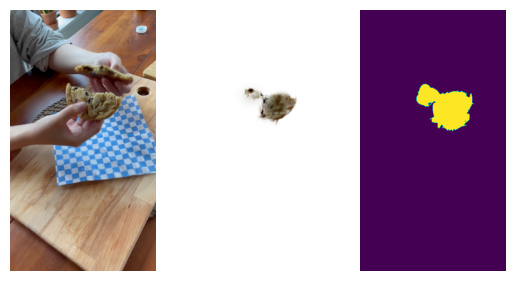

In [70]:
with torch.no_grad():
    rendering = render(target_view, gaussians, pipeline, bg_color, cam_type=cam_type)["render"]
    target_img = to8b(rendering).transpose(1,2,0)
    target_seg = render_segmentation(target_view, gaussians, pipeline, bg_color, point_mask)["render"]
    target_img_seg = to8b(target_seg.detach()).transpose(1,2,0)
    rendered_mask = render_mask(target_view, gaussians, pipeline, bg_color, precomputed_mask=point_mask.float())["mask"]
    rendered_mask = rendered_mask.squeeze().detach().cpu() > 0

plt.subplot(1,3,1)
plt.imshow(target_img)
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(target_img_seg)
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(rendered_mask.detach().cpu())
plt.axis("off")
plt.show()

## Post-Process

In [129]:
opacity = gaussians._opacity
shs = gaussians.get_features
means3D = gaussians.get_xyz
scales = gaussians._scaling
rotations = gaussians._rotation
ts = torch.tensor(view.time).to(means3D.device).repeat(means3D.shape[0],1)
means3D_final, scales_final, rotations_final, opacity_final, shs_final = gaussians._deformation(means3D, scales, 
                                                                rotations, opacity, shs, ts)

selected_xyz = means3D_final[mask.cpu()].data
selected_score = point_scores[mask.cpu()]
selected_xyz, thresh, mask_ = postprocess_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask=mask.clone(), max_time=10)
# filtered_points, filtered_mask, thresh = postprocess_grad_based_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask=mask_.clone(), 
#                                                                                     gaussians=gaussians, view=view, sam_mask=ref_mask.clone(), 
#                                                                                     pipeline_args=pipeline, bg_color=bg_color)
final_xyz, point_mask, final_normals = postprocess_growing(means3D_final, None, selected_xyz, None, max(thresh, 0.05), grow_iter = 1)

tensor(32192.9570, device='cuda:0') std_nearest_k_distance
tensor(1954.7667, device='cuda:0') std_nearest_k_distance
tensor(281.9975, device='cuda:0') std_nearest_k_distance
tensor(65.2150, device='cuda:0') std_nearest_k_distance
tensor(46.0530, device='cuda:0') std_nearest_k_distance
tensor(187.5402, device='cuda:0') std_nearest_k_distance
tensor(22.5561, device='cuda:0') std_nearest_k_distance
tensor(1.7806, device='cuda:0') std_nearest_k_distance
tensor(0.1741, device='cuda:0') std_nearest_k_distance
tensor(0.0705, device='cuda:0') std_nearest_k_distance


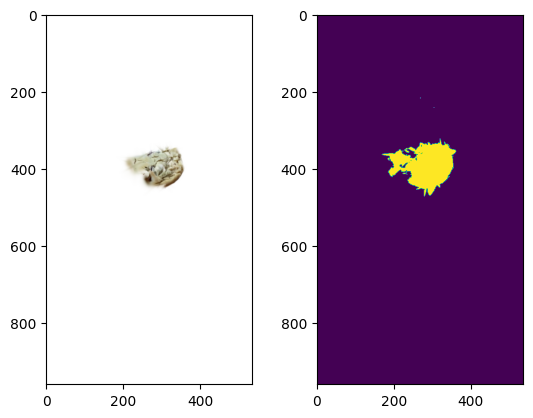

In [130]:
rendering = render_segmentation(view, gaussians, pipeline, bg_color, point_mask)["render"]
img_seg = to8b(rendering.detach()).transpose(1,2,0)
rendered_mask = render_mask(view, gaussians, pipeline, bg_color, precomputed_mask=point_mask.float())["mask"]
rendered_mask = rendered_mask.squeeze().detach().cpu() > 0

plt.subplot(1,2,1)
plt.imshow(img_seg)
plt.subplot(1,2,2)
plt.imshow(rendered_mask.detach().cpu())
plt.show()

In [20]:
# final_mask = point_mask.float().detach().clone().unsqueeze(-1)
# final_mask.requires_grad = True

# background = torch.zeros(final_mask.shape[0], 3, device = 'cuda')
# rendered_mask_pkg = render_mask(view, gaussians, pipeline, bg_color, precomputed_mask=final_mask)

# tmp_target_mask = torch.tensor(origin_ref_mask, device=rendered_mask_pkg['mask'].device)
# tmp_target_mask = torch.nn.functional.interpolate(tmp_target_mask.unsqueeze(0).unsqueeze(0).float(), size=rendered_mask_pkg['mask'].shape[-2:] , mode='bilinear').squeeze(0)
# tmp_target_mask[tmp_target_mask > 0.5] = 1
# tmp_target_mask[tmp_target_mask != 1] = 0

# loss = 30*torch.pow(tmp_target_mask - rendered_mask_pkg['mask'], 2).sum()
# loss.backward()

# grad_score = final_mask.grad.clone()
# final_mask = final_mask - grad_score
# final_mask[final_mask <= 0] = 0
# final_mask[final_mask != 0] = 1
# final_mask *= point_mask.unsqueeze(-1)

In [ ]:
# rendered_mask = render_mask(view, gaussians, pipeline, bg_color, precomputed_mask=final_mask.float())["mask"]
# rendered_mask = rendered_mask.squeeze().detach().cpu() > 0

# # plt.imshow((view.original_image).permute([1,2,0]).detach().cpu())
# # show_mask(rendered_mask, plt.gca())
# plt.imshow(rendered_mask.int)
# plt.axis('off')
# plt.show()

## Generate refined segmentation video

In [71]:
from utils.segment_utils import *

render_images = []
for idx, view in enumerate(tqdm(cameras, desc="Rendering progress")):
    #! post-process
    opacity = gaussians._opacity
    shs = gaussians.get_features
    means3D = gaussians.get_xyz
    scales = gaussians._scaling
    rotations = gaussians._rotation
    ts = torch.tensor(view.time).to(means3D.device).repeat(means3D.shape[0],1)
    means3D_final, scales_final, rotations_final, opacity_final, shs_final = gaussians._deformation(means3D, scales, 
                                                                    rotations, opacity, shs, ts)
    
    selected_xyz = means3D_final[mask.cpu()].data
    # selected_score = point_scores[mask.cpu()]
    filtered_points, thresh, mask_ = postprocess_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask = mask.clone(), max_time=3)
    # filtered_points, filtered_mask, thresh = postprocess_grad_based_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask=mask_.clone(), 
    #                                                                                     gaussians=gaussians, view=view, sam_mask=ref_mask.clone(), 
    #                                                                                     pipeline_args=pipeline.extract(args), bg_color=bg_color)

    final_xyz, point_mask, final_normals = postprocess_growing(means3D_final, None, filtered_points, None, max(thresh, 0.05), grow_iter = 1)
    
    #! render
    rendering = render_segmentation(view, gaussians, pipeline, bg_color, point_mask)["render"]
    render_images.append(to8b(rendering.detach()).transpose(1,2,0))

    torch.cuda.empty_cache()
    
imageio.mimwrite(os.path.join(MODEL_PATH, 'video', "ours_{}".format(GAUSSIAN_ITERATION), 'video_seg_1.mp4'), render_images, fps=30)

Rendering progress:   0%|          | 0/300 [00:00<?, ?it/s]

Rendering progress: 100%|██████████| 300/300 [00:07<00:00, 40.28it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1352, 1014) to (1360, 1024) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x585eb40] Warning: data is not aligned! This can lead to a speed loss


## Quantative Results

In [142]:
miou = 0.
macc = 0.
with torch.no_grad():
     for idx, view in enumerate(tqdm(test_views)):
          #! post-process
          opacity = gaussians._opacity
          shs = gaussians.get_features
          means3D = gaussians.get_xyz
          scales = gaussians._scaling
          rotations = gaussians._rotation
          ts = torch.tensor(view.time).to(means3D.device).repeat(means3D.shape[0],1)
          means3D_final, scales_final, rotations_final, opacity_final, shs_final = gaussians._deformation(means3D, scales, 
                                                                           rotations, opacity, shs, ts)
          
          selected_xyz = means3D_final[mask.cpu()].data
          # selected_score = point_scores[mask.cpu()]
          filtered_points, thresh, mask_ = postprocess_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask = mask.clone(), max_time=10)
          # filtered_points, filtered_mask, thresh = postprocess_grad_based_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask=mask_.clone(), 
          #                                                                                     gaussians=gaussians, view=view, sam_mask=ref_mask.clone(), 
          #                                                                                     pipeline_args=pipeline.extract(args), bg_color=bg_color)

          final_xyz, point_mask, final_normals = postprocess_growing(means3D_final, None, filtered_points, None, max(thresh, 0.05), grow_iter = 1)
          
          #! render
          rendered_mask = render_mask(view, gaussians, pipeline, bg_color, precomputed_mask=point_mask.float())["mask"]
          rendered_mask = rendered_mask.squeeze().detach().cpu() > 0
          rendered_mask = rendered_mask.int().detach().cpu()

          gt_mask = view.gt_mask
          gt_mask = torch.nn.functional.interpolate(gt_mask.float()[None, ...], rendered_mask.shape[-2:], mode='bilinear')[0, 0, :, :]
          
          #! metrics
          iou = (rendered_mask * gt_mask).sum() / (rendered_mask + gt_mask).sum()
          iou += ((1 - rendered_mask) * (1 - gt_mask)).sum() / ((1 - rendered_mask) + (1 - gt_mask)).sum()
          iou /= 2
          acc = (rendered_mask == gt_mask).count_nonzero() / gt_mask.numel()
          miou += iou
          macc += acc
          
          torch.cuda.empty_cache()
     
     miou /= len(views)
     macc /= len(views)
     print("mIoU: %.4f" % (miou * 100))
     print("mAcc: %.4f" % (macc * 100))
     
        

100%|██████████| 134/134 [00:04<00:00, 30.57it/s]

mIoU: 41.9197
mAcc: 96.4341
